# Final Assignment

# Correlation Between Companies in The Same Industry

Summary of Contents

- [1 Introduction](#toc_1)
- [2 Questions 2 heading](#toc_2)
- [3 Import Required Libraries](#toc_3)


<a name="toc_1"></a>
# Introduction

<a name="toc_2"></a>
# Questions

Are pairs in the same industry more closely correlated in their price movements than random pairs

If pairs are more closely correlated, do they also show higher levels of co-integration.

How many different stocks would we have to obtain data for to have a sufficient sample size?

How many pairs would would be need to select to have a sufficient sample size?

Do some industries show better correlation than others?

If there is a corrleation difference, is the correlation difference significant over a longer period such as a year vs a shorter period such as one month.



<a name="toc_3"></a>
# Import Required Libraries

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

In [2]:
import itertools

In [3]:
from random import sample

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Inputs

In [5]:
# Target Input Files
STOCK_PRICES_FNAME = "prices_shares.csv"
FX_PRICES_FNAME = "prices_fx.csv"
SP500_MEMBERS_FNAME = "sp500_info.csv"

#FILEPATH = "C:\\Dropbox\\Variance\\UNSW\\ZZEN9021\\"

In [6]:
# List of tickers/symbols of currencies that we wish to handle
FX_TICKERS = ["AUDUSD=X", "HKDUSD=X", "JPYUSD=X", "SGDUSD=X"]

The key data we are accessing is pricing information for stocks and fx rates.

Periodically we need to refresh this information as components of the indexes change, corporate actions occur etc.

However, obtaining this information requires downloading it and thus we want to limit that to when required and not download it every time we run the program.

We thus set a flag (REFRESH_DATA) which we can adjust before running the program identifying  whether to refresh our data or not.

In [7]:
# When running within Ed this needs to remain as False as their are restrictions on accessing external web sites
REFRESH_DATA = False

Set constants to determine limits on file size and number of pairs processed to limit processing and memory requirements.

In [8]:
# Instead of choosing all 500 names from the S&P500, pick a selection to reduce the file sizes
SP500_SAMPLE_SIZE = 100

# From our list of all generated pairs, select a random sample to reduce processing requiremens
#RDM_SAMPLE_SIZE = 20000
RDM_SAMPLE_SIZE = 4000

# Obtain Names in SP500

If the refresh data flag is set to True, we run the function to scrape the list of names in the S&P500 from Wikipedia and save this to a csv file.

If flag is set to false, the program will use the current version of the csv file.

In [9]:
def obtain_sp500_info():
    """
    Function to Scrape Details About S&P500 Components from Wikipedia.
    Saves the current S&P Components into a csv file.
    """

    # Scrape the list of components companies in the S&P500 as per Wikipedia
    table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    
    # Take the first item in the list obtained from table which contains a dataframe of current S&P components 
    df = table[0]
      
    # Save the component stocks to a csv file
    df.to_csv(SP500_MEMBERS_FNAME, index=False)
    
# If refresh flag is True, download current data via running the obtain_sp_500_info function
if REFRESH_DATA:
    obtain_sp500_info()
    

Read the Most current version of the csv file that contains the S&P component information.

In [10]:
sp500_info_df = pd.read_csv(SP500_MEMBERS_FNAME)
sp500_info_df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [12]:
# Trim the number of S&P500 members we are going to review given processing constraints

sp500_info_df = sp500_info_df[:SP500_SAMPLE_SIZE].copy()

Review the number of members to check that it equals the input constant SP500_SAMPLE_SIZE and also that there are no duplicate symbols

In [13]:
print(SP500_SAMPLE_SIZE)
print(sp500_info_df['Symbol'].count())
print(len(sp500_info_df['Symbol'].unique()))

100
100
100


<span style="color:green">&#x2705;</span>

Check for any periods in the stock names.  Yahoo Finance, which is where we download the prices from, uses the convention that A shares and B shares utilize dashes in their names instead of periods.

In [14]:
sp500_info_df[sp500_info_df['Symbol'].str.contains(".", regex=False)]

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
65,BRK.B,Berkshire Hathaway,Financials,Multi-Sector Holdings,"Omaha, Nebraska",2010-02-16,1067983,1839
81,BF.B,Brown–Forman,Consumer Staples,Distillers & Vintners,"Louisville, Kentucky",1982-10-31,14693,1870


In [15]:
# We need to replace periods with dashs within the Symbol columns for S&P500 related names as per Yahoo Finance convention
sp500_info_df['Symbol'] = sp500_info_df['Symbol'].str.replace(".", "-", regex=False)

# Check to ensure this was successful
sp500_info_df[sp500_info_df['Symbol'].str.contains(".", regex=False)]

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded


<span style="color:green">&#x2705;</span>

# Obtain Prices From CSV or Yahoo Finance

If we have chosen to refresh the data, we will now download the latest prices from Yahoo Finance using the yfinance Library.

We will download prices for both our stocks and also for the Foreign Exchange (FX) rates.

We will then update the pricing related csv files.

In [16]:
if REFRESH_DATA:
    
    # Download stock data and FX data from yfinance
    raw_stock_prices_df = yf.download(list(sp500_info_df['Symbol']), start="2022-01-01", end="2022-12-31")["Adj Close"]
    raw_fx_prices_df = yf.download(FX_TICKERS, start="2022-01-01", end="2022-12-31")["Adj Close"]
    
    # Write new prices to csv
    raw_stock_prices_df.to_csv(STOCK_PRICES_FNAME)
    raw_fx_prices_df.to_csv(FX_PRICES_FNAME)



Whether we have just refreshed the prices or not, we will read the share and FX prices from their csv files.  If refreshed, they will contain the data just downloaded.  If not, the prior version of the file.

In [17]:
# Read the Daily Prices for the Stocks and FX Rates from their respective csv files
raw_stock_prices_df = pd.read_csv(STOCK_PRICES_FNAME)
raw_fx_prices_df = pd.read_csv(FX_PRICES_FNAME)
    

## Review the Raw FX Data

In [18]:
raw_fx_prices_df.describe()

,AUDUSD=X,HKDUSD=X,JPYUSD=X,SGDUSD=X
count,261.000000,259.000000,261.000000,261.000000
mean,0.695038,0.127714,0.007659,0.725619
std,0.031389,0.000396,0.000634,0.013144
min,0.622394,0.127372,0.006659,0.695082
25%,0.674332,0.127400,0.007209,0.716692
50%,0.695300,0.127457,0.007465,0.726639
75%,0.718649,0.128077,0.008143,0.737300
max,0.758570,0.128718,0.008789,0.745379


It quite difficult to analyze the JPY and HKD columns given they are inverted vs how they are conventionally displayed.

Inverting them for reasonableness analysis:

In [19]:
fx_summ = raw_fx_prices_df.describe()
# Invert FX Rate for display purposes for JPY and HKD to what is conventionally displayed
fx_summ.loc[['mean', 'min', 'max'],['JPYUSD=X', 'HKDUSD=X']] \
            = 1 / fx_summ.loc[['mean', 'min', 'max'],['JPYUSD=X', 'HKDUSD=X']]
fx_summ


,AUDUSD=X,HKDUSD=X,JPYUSD=X,SGDUSD=X
count,261.000000,259.000000,261.000000,261.000000
mean,0.695038,7.829972,130.558193,0.725619
std,0.031389,0.000396,0.000634,0.013144
min,0.622394,7.851000,150.175992,0.695082
25%,0.674332,0.127400,0.007209,0.716692
50%,0.695300,0.127457,0.007465,0.726639
75%,0.718649,0.128077,0.008143,0.737300
max,0.758570,7.768900,113.785000,0.745379


<div class="alert alert-block alert-success">
Min and max ranges as well as distributions seem in line with the known characteristics of the currencies
</div>

<div class="alert alert-block alert-danger">
We do not have the same number of records for each currency
</div>

<p style="background-color:Yellow;">test</p>

&#10060;

To fix this we will resample the data using the ffil() function.
First though we'll create a copy of the data to avoid changing original data removing need to reload if rerunning workbook

In [20]:
 fx_prices = raw_fx_prices_df.copy()

Prior to doing the resampling and for later analysis it is better if we convert dates from being string values a column,  to Datetime values and also set them as the index.

In [21]:
# Format the Date and set as the Index
fx_prices['Date'] = pd.to_datetime(fx_prices['Date'], format = "%Y-%m-%d")
fx_prices = fx_prices.set_index('Date', drop=True)

In [22]:
# Resampling data to fill any missing values
# This will also give a price for the week-ends, but that will get dropped later when we merge with the share prices df
fx_prices = fx_prices.resample('D').last().ffill()

In [23]:
# Check the column counts to ensure they are now consistent
fx_prices.describe().loc['count']

AUDUSD=X    365.0
HKDUSD=X    365.0
JPYUSD=X    365.0
SGDUSD=X    365.0
Name: count, dtype: float64

&#x2705;

Here is how our FX data now looks:

In [24]:
fx_prices

,AUDUSD=X,HKDUSD=X,JPYUSD=X,SGDUSD=X
Date,,,,
2021-12-31,0.724980,0.128245,0.008691,0.739694
2022-01-01,0.724980,0.128245,0.008691,0.739694
2022-01-02,0.724980,0.128245,0.008691,0.739694
2022-01-03,0.726818,0.128272,0.008685,0.741730
2022-01-04,0.719800,0.128243,0.008671,0.739033
...,...,...,...,...
2022-12-26,0.671249,0.128147,0.007531,0.739809
2022-12-27,0.674459,0.128121,0.007532,0.742501
2022-12-28,0.672993,0.128199,0.007491,0.742060


&#x2705;

## Review the Raw Stock Price Data

In [25]:
raw_stock_prices_df

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,CZR,GOOG,GOOGL,KMX,LNT,MMM,MO,T,TECH,WRB
0,2021-12-31,157.838791,17.959999,227.873291,176.032745,126.516022,130.465149,136.453796,44.450001,404.244263,...,93.529999,144.679504,144.852005,130.229996,58.660084,165.659805,42.002319,16.512590,128.615036,53.633770
1,2022-01-03,154.908508,18.750000,224.928452,180.434280,126.534714,130.200043,134.805573,44.549999,397.086761,...,93.470001,145.074493,144.991501,127.010002,58.068417,165.762405,42.516380,17.069727,121.268661,52.898167
2,2022-01-04,149.671661,19.020000,225.184921,178.144302,126.291771,128.963058,131.635162,45.130001,394.249084,...,89.949997,144.416504,144.399506,123.860001,57.944363,168.084595,43.455868,17.210686,116.353661,53.685848
3,2022-01-05,147.107666,18.680000,224.614975,173.405685,126.955162,130.082245,131.043732,44.599998,387.306091,...,84.150002,137.653503,137.774994,119.349998,58.459679,167.394470,43.110207,17.593296,108.077499,53.086952
4,2022-01-06,147.622406,18.570000,229.554672,170.510956,126.357155,128.069656,131.024307,44.860001,368.602905,...,86.599998,137.550995,137.747498,119.099998,58.221104,166.004898,43.615406,17.526171,106.041412,53.991798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2022-12-23,148.481888,12.710000,141.008743,131.477127,158.336075,169.002655,106.645416,63.380001,263.014862,...,43.090000,89.809998,89.230003,60.160000,54.385517,116.794731,44.347225,17.485210,82.562065,72.699142
248,2022-12-27,148.800278,12.530000,142.721176,129.652435,158.229309,167.998657,107.029884,63.619999,262.243866,...,41.750000,87.930000,87.389999,60.419998,55.103447,116.872505,44.577396,17.628452,82.043106,73.154442
249,2022-12-28,147.347595,12.320000,142.996735,125.674019,157.491486,166.368362,106.300385,62.599998,260.079224,...,39.990002,86.459999,86.019997,59.240002,54.297005,114.996246,43.973183,17.399265,80.526199,72.055794
250,2022-12-29,150.332550,12.700000,143.990723,129.233658,157.811859,165.066132,108.745201,63.110001,265.278412,...,41.439999,88.949997,88.449997,61.259998,55.103447,117.212761,43.992367,17.618904,84.298523,72.491287


At a very high level:

* Date range looks correct.
* We have a column for each for stock and also a column for the date (which we will need convert to be the index later)


**Lets Review the price values for reasonableness**

In [26]:
print(f"Minimium Share Price Value Across All Stocks: ${raw_stock_prices_df.select_dtypes(include='number').min().min():,.02f}")
print(f"Maximum Share Price Value Across All Stocks: ${raw_stock_prices_df.select_dtypes(include='number').max().max():,.02f}")
print(f"Mean Share Price Value Across All Stocks: ${raw_stock_prices_df.select_dtypes(include='number').mean().mean():,.02f}")

Minimium Share Price Value Across All Stocks: $6.38
Maximum Share Price Value Across All Stocks: $2,703.26
Mean Share Price Value Across All Stocks: $175.99


The range of values for individual shares prices is quite large and thus direct comparision of absolute values would required scaling of the prices.
However, the range seems reasonable given the dataset - there are no negative values and no extremely large or small values.

&#x2705;

Lets create a scatter plot to visualize the price data

Text(0.5, 1.0, 'Mean Price for Each Company')

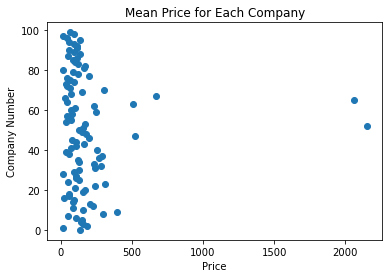

In [27]:
av_prices_by_stock = raw_stock_prices_df.select_dtypes(include='number').mean()
av_prices_by_stock.index = pd.Series(range(len(av_prices_by_stock)))
plt.scatter(x = av_prices_by_stock.values,
            y = av_prices_by_stock.index,
           )
plt.xlabel('Price')
plt.ylabel('Company Number')
plt.title('Mean Price for Each Company')

<div class="alert alert-block alert-warning">
<b>Not Great:</b> That does not look so great with a small number of obvious outliers.
</div>

Lets check to see if these represent errors or just outliers.

In [28]:
# Largest two price values by stock
raw_stock_prices_df.select_dtypes(include='number').max().sort_values()[-2:]


AZO     2579.00000
BKNG    2703.26001
dtype: float64

Checking these manually to price sources **, the prices look accurate.  Thus the values represent outliers rather than errors.

While there are several ways to handle these outliers depending the analysis being performed and the reason for the outliers, for our analysis we are going to retain them in our data set.

** 
https://finance.yahoo.com/quote/NVR?p=NVR&.tsrc=fin-srch
https://finance.yahoo.com/quote/BKNG?p=BKNG&.tsrc=fin-srch

**Examing the Number of Records for Each Stock**

In [29]:
print(raw_stock_prices_df.describe().loc['count'].describe())

count    100.0
mean     252.0
std        0.0
min      252.0
25%      252.0
50%      252.0
75%      252.0
max      252.0
Name: count, dtype: float64


<div class="alert alert-block alert-success">
The maximum number of rows is 252, and this is the case for >75% of the rows.  As a reasonableness check, there are 260 (52 * 5) week days in the year and some of these will be public holidays.  So we expect somewhere around 250 trading days in a year given stock markets are not open on week-ends and we have to then deduct for public holidays - so 252 looks reasonable.
</div>

<div class="alert alert-block alert-danger">
Some symbols are missing prices and we will eliminate these names to ensure we have sufficient and consistent pricing data.  For example it appears one name only has prices for 11 days, whereas most have 252 days.  We will deal with that in the formatting of the pricing data.
</div>

# Format Share Pricing Data

## Convert Share Prices to USD Equivalent

In [30]:
# First we create a copy of the dataset to avoid changing original data removing need to reload if rerunning workbook
#stock_prices_usd = raw_stock_prices_df.copy()

In [31]:
stock_prices_usd = raw_stock_prices_df

In [32]:
#Then we convert the dates to datetime format and set them as the index

stock_prices_usd['Date'] = pd.to_datetime(stock_prices_usd['Date'], format = "%Y-%m-%d")
stock_prices_usd = stock_prices_usd.set_index('Date', drop=True)

Now we add a column for the FX rate applicable given the ticker code format:
* Australian stocks have .AX in their ticker, 
* Japanese stocks have .T, 
* Hong Kong stocks .HK, 
* Singapore stocks .SI; and
* US stocks have no period in their ticker

In [33]:
# Add currency column based on ticker code format
for ticker in stock_prices_usd.columns:
    if ".AX" in ticker:
        stock_prices_usd[ticker] = stock_prices_usd[ticker] * fx_prices["AUDUSD=X"]
    elif ".HK" in ticker:
        stock_prices_usd[ticker] = stock_prices_usd[ticker] * fx_prices["HKDUSD=X"]
    elif ".T" in ticker:
        stock_prices_usd[ticker] = stock_prices_usd[ticker] * fx_prices["JPYUSD=X"]
    elif ".SI" in ticker:
        stock_prices_usd[ticker] = stock_prices_usd[ticker] * fx_prices["SGDUSD=X"]

## Eliminate shares with less than 245 trading days

In [34]:
# Identify Names Which Should be Eliminated
low_counts = stock_prices_usd.count()[stock_prices_usd.count()<250]
print(low_counts)

low_counts = list(low_counts.index)
print(low_counts)

Series([], dtype: int64)
[]


In [35]:
# Eliminate Names with a Low Number of Trading Days Present
stock_prices_usd = stock_prices_usd.drop(columns=low_counts).copy()

In [36]:
# Check removal was successful
stock_prices_usd.count().min()

252

&#x2705;

## Fill Prices for Names Missing only a Small Number of Days

In [37]:
# Forward fill any missing stock prices
stock_prices_usd.fillna(method='ffill', inplace=True)

# Backward fill any remaining missing stock prices
stock_prices_usd.fillna(method='bfill', inplace=True)

stock_prices_usd

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,CZR,GOOG,GOOGL,KMX,LNT,MMM,MO,T,TECH,WRB
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-31,157.838791,17.959999,227.873291,176.032745,126.516022,130.465149,136.453796,44.450001,404.244263,567.059998,...,93.529999,144.679504,144.852005,130.229996,58.660084,165.659805,42.002319,16.512590,128.615036,53.633770
2022-01-03,154.908508,18.750000,224.928452,180.434280,126.534714,130.200043,134.805573,44.549999,397.086761,564.369995,...,93.470001,145.074493,144.991501,127.010002,58.068417,165.762405,42.516380,17.069727,121.268661,52.898167
2022-01-04,149.671661,19.020000,225.184921,178.144302,126.291771,128.963058,131.635162,45.130001,394.249084,554.000000,...,89.949997,144.416504,144.399506,123.860001,57.944363,168.084595,43.455868,17.210686,116.353661,53.685848
2022-01-05,147.107666,18.680000,224.614975,173.405685,126.955162,130.082245,131.043732,44.599998,387.306091,514.429993,...,84.150002,137.653503,137.774994,119.349998,58.459679,167.394470,43.110207,17.593296,108.077499,53.086952
2022-01-06,147.622406,18.570000,229.554672,170.510956,126.357155,128.069656,131.024307,44.860001,368.602905,514.119995,...,86.599998,137.550995,137.747498,119.099998,58.221104,166.004898,43.615406,17.526171,106.041412,53.991798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,148.481888,12.710000,141.008743,131.477127,158.336075,169.002655,106.645416,63.380001,263.014862,338.450012,...,43.090000,89.809998,89.230003,60.160000,54.385517,116.794731,44.347225,17.485210,82.562065,72.699142
2022-12-27,148.800278,12.530000,142.721176,129.652435,158.229309,167.998657,107.029884,63.619999,262.243866,335.089996,...,41.750000,87.930000,87.389999,60.419998,55.103447,116.872505,44.577396,17.628452,82.043106,73.154442
2022-12-28,147.347595,12.320000,142.996735,125.674019,157.491486,166.368362,106.300385,62.599998,260.079224,328.329987,...,39.990002,86.459999,86.019997,59.240002,54.297005,114.996246,43.973183,17.399265,80.526199,72.055794


# Create a Universe of Pairs

Now that we have imported and cleansed the data, we need to start manipulating it to get the answers required.

Key to this is breaking the price data for all the companies into pairs that can be analyzed.  For Example, Microsoft (MSFT) vs Google (GOOGL).


Using all the names we have data for, we can create a list of all possible pair combinations using the itertools library.

In [38]:
all_possible_pairs = [list(pair) for pair in itertools.combinations(stock_prices_usd.columns, 2)]

print(f"The Number of All Possible Unique Pairs is: {len(all_possible_pairs):,.0f}")
print(f"\nSome Examples: {all_possible_pairs[:5]} \n{all_possible_pairs[-5:]}")


The Number of All Possible Unique Pairs is: 4,950

Some Examples: [['A', 'AAL'], ['A', 'AAP'], ['A', 'AAPL'], ['A', 'ABBV'], ['A', 'ABC']] 
[['MO', 'TECH'], ['MO', 'WRB'], ['T', 'TECH'], ['T', 'WRB'], ['TECH', 'WRB']]


We may want to instead look at a sample of names, instead of the full universe.  This may be because we have processing constrainsts etc.  However, we want a random sample rather than just picking the first 100 names in case their is some bias in the way they are ordered.

We have set the sample size via the input constant (RDM_SAMPLE_SIZE) in the Set Inputs section.

In [39]:
# Select a sample of pairs randomly from the our universe of all possible pairs
random_pairs = sample(all_possible_pairs, RDM_SAMPLE_SIZE)
print(random_pairs[:5])

[['BIIB', 'CAH'], ['ALGN', 'BMY'], ['BALL', 'CNC'], ['ALK', 'BRK-B'], ['AMP', 'BDX']]


## Add Industry to Pairs List

The key factor we are seeking to test is Industry.  That is, if in names in the same industry show better correlation or related statistics vs random pairs. 

To do this we are going to have to merge information from multiple inputs:
- the ticker names for the pairs will come from the list of pairs we generated;
- the Industry name will come from the sp500_info_df
- Same Industry Column will be a engineered column we create

The Same Industry column will make queries and analysis on the dataset simplier.


In [40]:
# Build a DataFrame which lists all possible pairs, the industry of each name in the pair and if they are the same.

# Start with the all the pair combinations
all_possible_pairs_df = pd.DataFrame(all_possible_pairs, columns=['Ticker1', 'Ticker2'])

# write to csv to check file size
all_possible_pairs_df.to_csv("all_possible_pairs_df.csv")

# Add the Industry Name for the first ticker
all_possible_pairs_df = pd.merge(all_possible_pairs_df, sp500_info_df[['Symbol', 'GICS Sub-Industry']], how='inner', left_on = 'Ticker1', right_on = 'Symbol')
# Add the Industry name for the second ticker
all_possible_pairs_df = pd.merge(all_possible_pairs_df, sp500_info_df[['Symbol', 'GICS Sub-Industry']], how='inner', left_on = 'Ticker2', right_on = 'Symbol')

# Remove excess columns and tidy up column names
all_possible_pairs_df.drop(columns = ['Symbol_x', 'Symbol_y'], inplace=True)
all_possible_pairs_df.rename(columns={"GICS Sub-Industry_x": "Ind1", "GICS Sub-Industry_y": "Ind2"}, inplace=True)

# Create a new column 'Same Industry' which identifies if all the two names in the pair are from the same industry
all_possible_pairs_df['Same Industry'] = np.where(all_possible_pairs_df['Ind1'] == all_possible_pairs_df['Ind2'], 'Yes', 'No')
all_possible_pairs_df

,Ticker1,Ticker2,Ind1,Ind2,Same Industry
0,A,AAL,Health Care Equipment,Passenger Airlines,No
1,A,AAP,Health Care Equipment,Automotive Retail,No
2,AAL,AAP,Passenger Airlines,Automotive Retail,No
3,A,AAPL,Health Care Equipment,"Technology Hardware, Storage & Peripherals",No
4,AAL,AAPL,Passenger Airlines,"Technology Hardware, Storage & Peripherals",No
...,...,...,...,...,...
4945,LNT,WRB,Electric Utilities,Property & Casualty Insurance,No
4946,MMM,WRB,Industrial Conglomerates,Property & Casualty Insurance,No
4947,MO,WRB,Tobacco,Property & Casualty Insurance,No
4948,T,WRB,Integrated Telecommunication Services,Property & Casualty Insurance,No


Construct a DataFrame for the Random Pairs sample in the same format as that for all the possible pairs.

We have done this via merge given we are selecting the rows via two columns rather than a single column.  Other methods also work but the merge gets the job done quite well.

In [41]:
#Build the base df from the list of list of random pairs
random_pairs_df = pd.DataFrame(random_pairs, columns=['Ticker1', 'Ticker2'])

# Add the extra columns required via merging with the df containing all the pairs
random_pairs_df = pd.merge(random_pairs_df, all_possible_pairs_df, how='inner',
                          left_on= ['Ticker1', 'Ticker2'],
                          right_on= ['Ticker1', 'Ticker2'])

random_pairs_df


,Ticker1,Ticker2,Ind1,Ind2,Same Industry
0,BIIB,CAH,Biotechnology,Health Care Distributors,No
1,ALGN,BMY,Health Care Supplies,Pharmaceuticals,No
2,BALL,CNC,"Metal, Glass & Plastic Containers",Managed Health Care,No
3,ALK,BRK-B,Passenger Airlines,Multi-Sector Holdings,No
4,AMP,BDX,Asset Management & Custody Banks,Health Care Equipment,No
...,...,...,...,...,...
3995,AMGN,BAC,Biotechnology,Diversified Banks,No
3996,ANSS,WRB,Application Software,Property & Casualty Insurance,No
3997,CAT,CPB,Construction Machinery & Heavy Transportation ...,Packaged Foods & Meats,No
3998,ACGL,CNC,Reinsurance,Managed Health Care,No


### Analysis of Names by Sub_Industry ###

In [42]:
sp500_info_df['GICS Sub-Industry'].describe()

count                       100
unique                       65
top       Health Care Equipment
freq                          5
Name: GICS Sub-Industry, dtype: object

In [43]:
print(f"The Maxium Number of Members within a Sub-Industry Group is: {sp500_info_df.groupby('GICS Sub-Industry')['Symbol'].count().max()}")
print(f"The Maxium Number of Members within a Sub-Industry Group is: {sp500_info_df.groupby('GICS Sub-Industry')['Symbol'].count().min()}")

The Maxium Number of Members within a Sub-Industry Group is: 5
The Maxium Number of Members within a Sub-Industry Group is: 1


### Build and Display Graphs Analysing the Distribution of the Sub-Industry Groups

In [44]:
# Get Counts of The Number of Names Within Each Sub-Industry
sub_industry_counts = sp500_info_df.groupby('GICS Sub-Industry')['Symbol'].count().sort_values(axis=0)

# Bucket The Industries into Those That Have a High Number of Members and "Others"
sub_industry_graph_series = sub_industry_counts[-8:]
sub_industry_graph_series['Other'] = sub_industry_counts[:-8].sum()

In [45]:
# Create a seaborn color palette for our graphs
colors = sns.color_palette("Blues", len(sub_industry_graph_series))

In [46]:
# Function to Create a Series of Graphs to Show the Distribution and Makeup of the Sub-Industry Membership
def display_subindustry_graphs(colors, sub_industry_counts, sub_industry_graph_series):
    
    fig = plt.figure(figsize=(10, 25))
    fig.suptitle('Sub-Industry Category Splits', y = 0.95, fontweight='bold')

    # Display Histogram Showing What Are the Most Common Number of Members Within a Sub-Industry Group
    ax = fig.add_subplot(4, 1, 1)
    ax.hist(sub_industry_counts,
            bins = len(np.arange(1,sub_industry_counts.max())+1),
            )
    ax.set_ylabel('Frequency of Occurence')
    ax.set_xlabel('Number of Members Within Sub-Index')
    ax.set_title('Breakout of the Number of Members Within Each Sub-Index')

    # Display Pie Chart
    ax = fig.add_subplot(4, 1, 2)
    ax.pie(sub_industry_graph_series,
        labels = sub_industry_graph_series.index,
        colors = colors,
            )
    ax.set_title('Sub_Industry Category Split', fontweight='bold')

    # Bar Chart of the Sub-Industries With the Most Members
    ax = fig.add_subplot(4, 1, 3)
    ax.barh(sub_industry_graph_series[:-1].index , sub_industry_graph_series[:-1].values)
    ax.set_title('Top Sector Member Numbers', fontweight='bold')

    # Display Box Plot
    ax = fig.add_subplot(4, 1, 4)
    ax.boxplot(sp500_info_df.groupby('GICS Sub-Industry')['Symbol'].count())
    ax.set_title('Distribution of Number of Members Within Each Sub-Industry', fontweight='bold')

    #fig.tight_layout()
    plt.subplots_adjust(hspace = 0.5)
    
    return fig

When we review the how many stocks/ companies fall into each Sub-Industry we see that most Sub-Industries only have a very small number of members.  However, there are also a small number of Sub-Industries that have 10 plus members.

So the distribution is definitely quite skewed.

The following graphs demonstrate that distribution and also highlights which Sub-Industry groups have the most number of members.

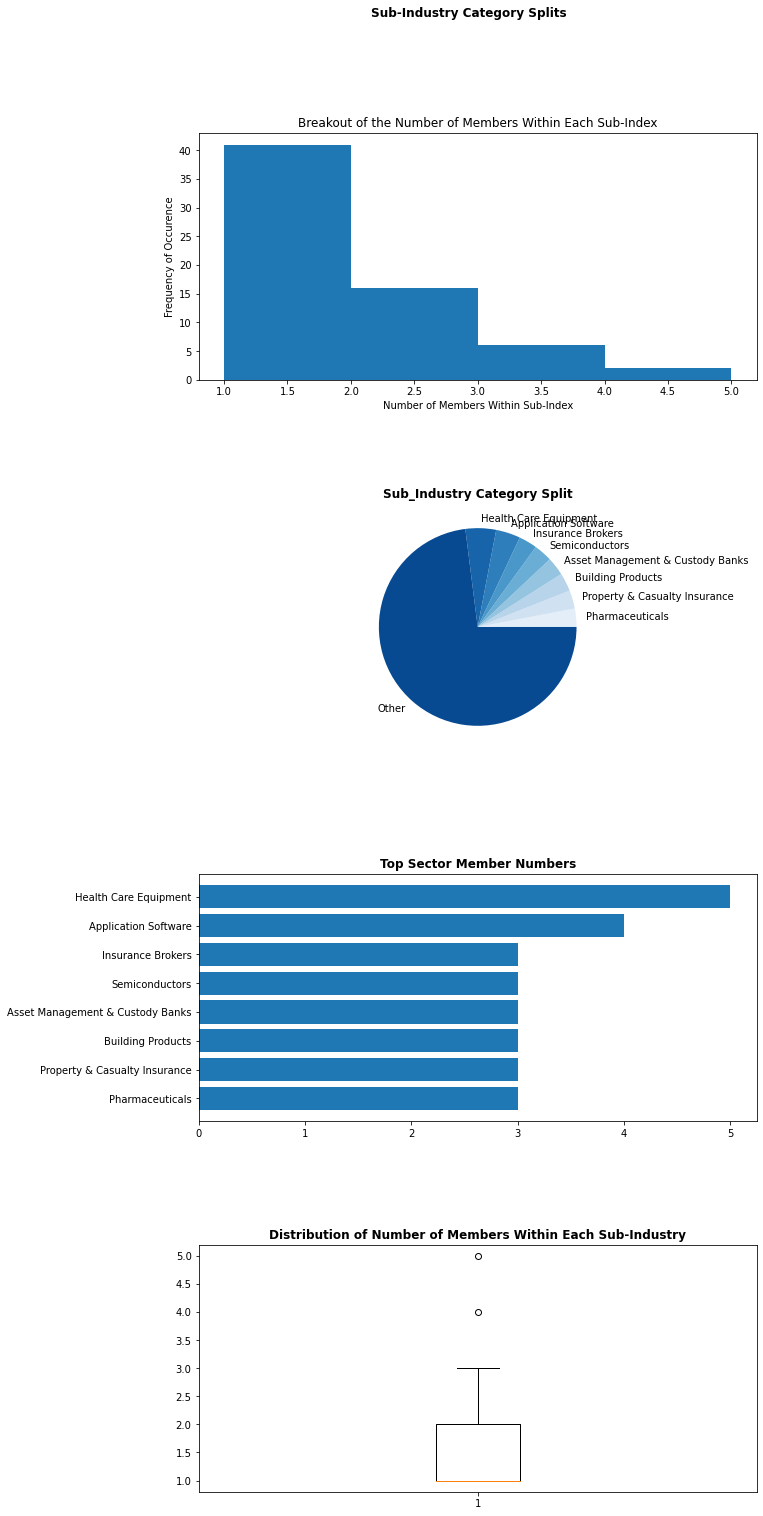

In [47]:
fig = display_subindustry_graphs(colors, sub_industry_counts, sub_industry_graph_series)
#plt.show()

Where the Sub-Industry only has a single member, comparing members within the same industry will not be possible.

In [48]:
print(f"The number of sub-industries with less than two members: {len(sub_industry_counts[sub_industry_counts <= 1])}")

The number of sub-industries with less than two members: 41


In [49]:
(sp500_info_df.groupby('GICS Sub-Industry')['Symbol'].count() == 1).count()

65

Given we are looking to compare companies within the same industry vs companies not in the same industry, one factor to consider is exluding those sectors which do not have at least 2 names in them.

In [50]:
sp500_info_df.groupby('GICS Sub-Industry')['Symbol'].count()

GICS Sub-Industry
Aerospace & Defense                           2
Agricultural Products & Services              2
Air Freight & Logistics                       1
Application Software                          4
Asset Management & Custody Banks              3
                                             ..
Technology Distributors                       1
Technology Hardware, Storage & Peripherals    1
Telecom Tower REITs                           1
Tobacco                                       1
Water Utilities                               1
Name: Symbol, Length: 65, dtype: int64

## Analyse Ratio of Same Industry Vs Different Industry Pairs

### Full Universe of Names

In [51]:
num_pairs_all = len(all_possible_pairs_df.index)
num_pairs_same_ind_all = len(all_possible_pairs_df[all_possible_pairs_df['Same Industry'] == 'Yes'].index)

print(f"Number of Pairs In Total: {num_pairs_all:,}")
print(f"Number of Pairs in the Same Industry: {num_pairs_same_ind_all:,}")
print(f"Percentage of pairs in the same industry: {num_pairs_same_ind_all/num_pairs_all * 100:,.02f}%")

Number of Pairs In Total: 4,950
Number of Pairs in the Same Industry: 50
Percentage of pairs in the same industry: 1.01%


### Sample

In [52]:
num_pairs_all_samp = len(random_pairs_df.index)
num_pairs_same_ind_samp = len(random_pairs_df[random_pairs_df['Same Industry'] == 'Yes'].index)

print(f"Number of Pairs In Total: {num_pairs_all_samp:,}")
print(f"Number of Pairs in the Same Industry: {num_pairs_same_ind_samp:,}")
print(f"Percentage of pairs in the same industry: {num_pairs_same_ind_samp/num_pairs_all_samp * 100:,.02f}%")

Number of Pairs In Total: 4,000
Number of Pairs in the Same Industry: 40
Percentage of pairs in the same industry: 1.00%


In [53]:
df = pd.DataFrame(data = [[num_pairs_all, num_pairs_same_ind_all, num_pairs_same_ind_all/num_pairs_all * 100], 
                          [num_pairs_all_samp, num_pairs_same_ind_samp, num_pairs_same_ind_samp/num_pairs_all_samp * 100]], 
                  columns=['Number of Total Pairs', 'Number of Pairs in Same Industry', '% of Pairs in the Same Industry'])
df.index = ['Entire Population', 'Sample']
df

,Number of Total Pairs,Number of Pairs in Same Industry,% of Pairs in the Same Industry
Entire Population,4950,50,1.010101
Sample,4000,40,1.000000


<div class="alert alert-block alert-success">
Our sample does seem representative of the total population in term pairs in the same industry vs all pairs.
</div>

# Correlation

# Calculate The Correlation Between Various Pairs

In [54]:
corr_array = []
for i in range(len(random_pairs_df)):
    
    #ratio = stock_prices_usd[pair[0]]/ stock_prices_usd[pair[1]]
    corr = stock_prices_usd[random_pairs[i][0]].corr(stock_prices_usd[random_pairs[i][1]])
    
    corr_array.append([random_pairs[i][0], random_pairs[i][1], corr])
    
    i += 1
    
corr_df = pd.DataFrame(data=corr_array, columns=['Ticker1', 'Ticker2', 'Correlation'])
corr_df = pd.merge(corr_df, random_pairs_df, how='inner',
                  left_on = ['Ticker1', 'Ticker2'], right_on = ['Ticker1', 'Ticker2'])

corr_df

,Ticker1,Ticker2,Correlation,Ind1,Ind2,Same Industry
0,BIIB,CAH,0.765953,Biotechnology,Health Care Distributors,No
1,ALGN,BMY,-0.727779,Health Care Supplies,Pharmaceuticals,No
2,BALL,CNC,-0.035880,"Metal, Glass & Plastic Containers",Managed Health Care,No
3,ALK,BRK-B,0.828995,Passenger Airlines,Multi-Sector Holdings,No
4,AMP,BDX,0.137405,Asset Management & Custody Banks,Health Care Equipment,No
...,...,...,...,...,...,...
3995,AMGN,BAC,-0.408589,Biotechnology,Diversified Banks,No
3996,ANSS,WRB,-0.754241,Application Software,Property & Casualty Insurance,No
3997,CAT,CPB,0.265568,Construction Machinery & Heavy Transportation ...,Packaged Foods & Meats,No
3998,ACGL,CNC,-0.062420,Reinsurance,Managed Health Care,No


In [55]:
stock_prices_usd.iloc[:,:5].head()

,A,AAL,AAP,AAPL,ABBV
Date,,,,,
2021-12-31,157.838791,17.959999,227.873291,176.032745,126.516022
2022-01-03,154.908508,18.750000,224.928452,180.434280,126.534714
2022-01-04,149.671661,19.020000,225.184921,178.144302,126.291771
2022-01-05,147.107666,18.680000,224.614975,173.405685,126.955162
2022-01-06,147.622406,18.570000,229.554672,170.510956,126.357155


## Analyze Correlations

We are analyzing the absolute values of the correlations as we are interested in the magnitude of the corrleations - negative correlations are as usual as positive ones.

In [56]:
corr_all = abs(corr_df['Correlation']).describe()
corr_same_ind = abs(corr_df[corr_df['Same Industry'] == 'Yes']['Correlation']).describe()

df = pd.DataFrame(corr_all)
df = pd.DataFrame({'Corr all': corr_all, 'Corr Same Industry': corr_same_ind})

df.loc['Median', :] \
= [abs(corr_df['Correlation']).median(), abs(corr_df[corr_df['Same Industry'] == 'Yes']['Correlation']).median()]
df

,Corr all,Corr Same Industry
count,4000.000000,40.000000
mean,0.437088,0.577879
std,0.268977,0.266691
min,0.000294,0.077514
25%,0.200766,0.443450
50%,0.419049,0.587549
75%,0.664703,0.796066
max,0.999787,0.999787
Median,0.419049,0.587549


<div class="alert alert-block alert-info">
<b>Finding:</b> At a summary level there does appear to be a higher correlation level for pairs in the same industry</div>

## Analyse by Industry : Are Some Industry Groups Better Than Others?

Build a DataFrame which gives us some summary info by Industry for Pairs Which are Both in the Same Industry

In [57]:
# Take the df of all correlations, extract same industry pairs and get the median correlation and count for those those pairs
df = corr_df[corr_df['Same Industry'] == 'Yes'].groupby('Ind1').agg(Median =('Correlation', 'median'),\
                                                                   Count=('Correlation','count'))
df = df.reset_index()
df['Median'] = abs(df['Median'])
df = df.sort_values(['Median', 'Count']).set_index('Ind1', drop=True)
df.index.name = ""


If we only have one pair in an industry, it is difficult to make any comparision of that industry vs another.  Thus we will limit our comparison to industries with at least 8 names in it.

In [58]:
# Limit our target dataframe to only the top 10 names by count frequency
df = df.sort_values('Count')
df = df.tail(10)
df = df.sort_values('Median')
df

,Median,Count
,,
Health Care Equipment,0.423079,8
Specialty Stores,0.444733,1
Pharmaceuticals,0.452582,2
Property & Casualty Insurance,0.478301,3
Insurance Brokers,0.516414,3
Specialty Chemicals,0.533372,1
Application Software,0.696114,5
Semiconductors,0.731294,2
Building Products,0.889304,2


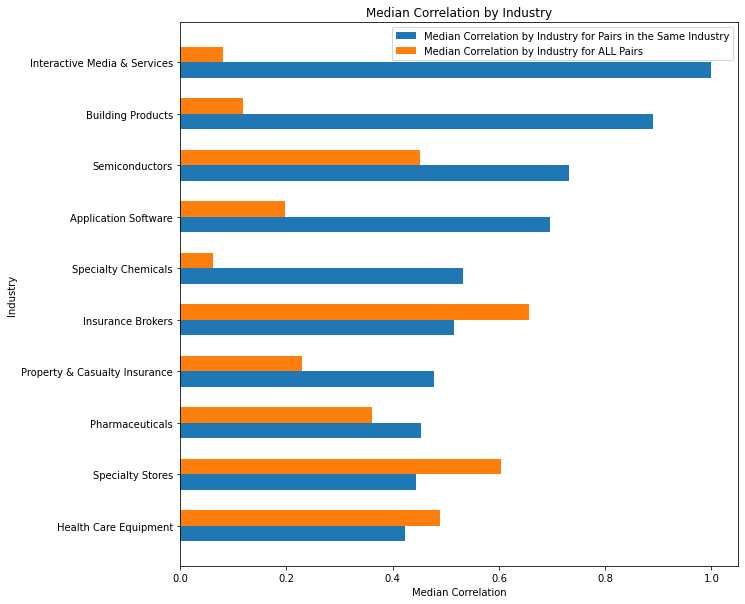

In [59]:
# Calculate median correlations
medians_same_ind = abs(df['Median'])
medians_all_ind = abs(corr_df.groupby('Ind1')['Correlation'].median())

# We only want to plot the industries that have sufficient same industry pairs
medians_all_ind = medians_all_ind[medians_all_ind.index.isin(df.index)]

# Create figure and axis
fig, ax = plt.subplots(figsize=[10,10])

# Set a width for the bars
bar_width = 0.3

# We have to define bar positions if we want the different plots to be side by side
bar1_positions = np.arange(len(medians_same_ind))
bar2_positions = bar1_positions + bar_width # Puts the position beside the prior bar

# Create our bar charts
ax.barh(bar1_positions, medians_same_ind, height=bar_width, label='Median Correlation by Industry for Pairs in the Same Industry')
ax.barh(bar2_positions, medians_all_ind, height=bar_width, label='Median Correlation by Industry for ALL Pairs')

# Define y labels and title
ax.set_yticks(bar1_positions + bar_width / 2)
ax.set_yticklabels(medians_same_ind.index)
ax.set_xlabel('Median Correlation')
ax.set_ylabel('Industry')
ax.set_title('Median Correlation by Industry')

# Show legend
ax.legend()

# Show plot
#plt.show()

<div class="alert alert-block alert-info">
<b>Finding:</b> The range of correlations does vary signficantly across industries
Looking for a pattern or characteristic, it appears that "old economy" industries generally offer higher correlations compared to new economy companies (software, biotech).  
Or another perspective, is that industries where the business models of the member companies is more stable have better correlations than those rapidly changing business models</div>

<div class="alert alert-block alert-info">
<b>Finding:</b> This graph also reinforces the earlier finding that the correlation levels are higher for pairs which are both in the same industry vs disparate pairs - as the same industry pairs have higher correlation for almost all industries</div>

# CoIntegration

In [60]:
#pscore_1yr, pvalue_1yr, _ = coint(train_series1,train_series2)

# References

wikipedia: 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

data sources: yahoo finance



# Discarded Graphs etc

array([[<AxesSubplot:xlabel='A', ylabel='A'>,
        <AxesSubplot:xlabel='AAL', ylabel='A'>,
        <AxesSubplot:xlabel='AAP', ylabel='A'>],
       [<AxesSubplot:xlabel='A', ylabel='AAL'>,
        <AxesSubplot:xlabel='AAL', ylabel='AAL'>,
        <AxesSubplot:xlabel='AAP', ylabel='AAL'>],
       [<AxesSubplot:xlabel='A', ylabel='AAP'>,
        <AxesSubplot:xlabel='AAL', ylabel='AAP'>,
        <AxesSubplot:xlabel='AAP', ylabel='AAP'>]], dtype=object)

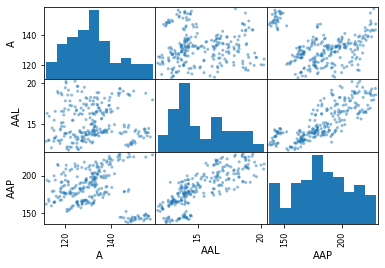

In [61]:
graph_df = stock_prices_usd.iloc[:,:3].copy()

pd.plotting.scatter_matrix(graph_df)

In [62]:
# A Pairplot on Correlations Might Show Something About Industries

# Not really!

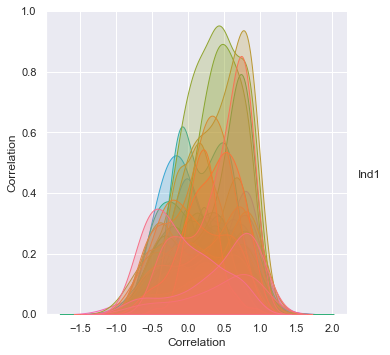

In [63]:

sns.set()
sns.pairplot(
    #data = corr_df.head(),
    data = corr_df,
    hue = 'Ind1',
    height = 5
        )


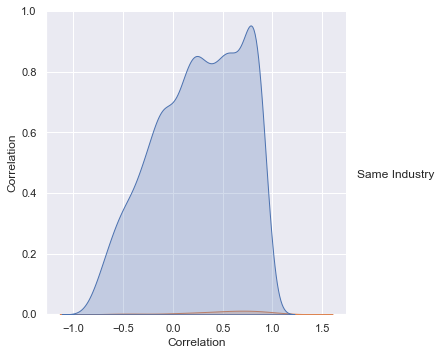

In [64]:
sns.pairplot(
    #data = corr_df.head(),
    data = corr_df,
    hue = 'Same Industry',
    height = 5
    
        )

In [65]:
# Observe when notebook was last run all the way through successfully

print(datetime.now())

2023-07-29 12:46:58.271557
